In this file, we create an MLP model using Keras. We train this model using the training data we collected in 'gesture_data_collection.ipynb'. Once the model is sufficiently well trained, we test the performance of the model.

In [1]:
import mediapipe as mp
import cv2
import os
import csv
import numpy as np
import json
import ast
import random
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras.utils import np_utils
import kerastuner as kt
import matplotlib.pyplot as plt

#Use this list to add the class names for each gesture
num_classes = 6
class_names = ["one", "two", "three", "four", "five", "other"] 

In [27]:
def calc_landmark_list(handedness, landmarks):
    landmark_point_list = []

    for landmark in landmarks:
        landmark_x = landmark.x
        landmark_y = landmark.y
        landmark_z = landmark.z
        landmark_point_list.append([landmark_x, landmark_y, landmark_z])
    
    landmark_point_list = np.array(landmark_point_list)
    max_val = landmark_point_list.max(axis = 0)
    min_val = landmark_point_list.min(axis = 0)
    x_max, x_min, y_max, y_min = max_val[0], min_val[0], max_val[1], min_val[1]
    x_diff = x_max - x_min
    y_diff = y_max - y_min
    landmark_point_list[:,0] = (landmark_point_list[:,0] - x_min)/x_diff
    landmark_point_list[:,1] = (landmark_point_list[:,1] - y_min)/y_diff
    landmark_point_list = landmark_point_list.reshape(63,)
    landmark_list = np.insert(landmark_point_list, 0, handedness)    
    return landmark_list

def get_training_landmarks(landmarks):
    landmarks_list = []
    for landmark in landmarks:
        landmarks_list.append([landmark.x, landmark.y, landmark.z])
    return landmarks_list

In [3]:
def collectClassTrainingData(class_id):
    writer = csv.writer(open("C:/Users/Pratham Goradia/OneDrive/Desktop/handEmoji/training_samples/training_" + str(class_id) +
                             ".csv", 'a', newline = ''))
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.7, min_tracking_confidence = 0.6)

    cam = cv2.VideoCapture(0)
    
    while True:
        valid, img = cam.read()
        if not valid:
            print("Failed to grab frame, closing..")
            break

        img = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)
        img.flags.writeable = False # To improve performance, optionally mark the image as not writeable to pass by reference.
        results = hands.process(img)
        img.flags.writeable = True
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        # Draw the hand annotations on the image.
        if(results.multi_hand_landmarks):
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            cv2.imshow("Landmark Hands", img)

        k = cv2.waitKey(1)
        if k%256 == 27:
            # ESC pressed
            print("Escape hit, closing...")
            break
        elif k%256 == 32:
            # SPACE pressed
            if(results.multi_hand_landmarks):
                for hand_landmarks in results.multi_hand_landmarks:
                    handedness = results.multi_handedness[0].classification[0].index
                    landmark_list = get_training_landmarks(hand_landmarks.landmark)
                    landmark_list.insert(0, class_id)
                    landmark_list.insert(1, handedness)
                    writer.writerow(landmark_list)
            else:
                print("No hand detected")
        #elif k%256 == 112:

    hands.close()
    cam.release()
    cv2.destroyAllWindows()

collectClassTrainingData(3)

Escape hit, closing...


In the below cell, we retrieve the training data from the csv files and prepare it so that it can be used to train the model. The training samples from all the files are extracted into a list and the list is shuffled. Each training sample(each item in the list) contains the following:
- The class label, 
- The handedness (left or right),
- 21 xyz coordinates, as string representations of lists, which represent the 21 landmarks detected on the hand. 

Firstly, the labels are separated from each training sample into a separate numpy array. One-hot-encoding is done on this array so that it matches the softmax output of the model. Next, the landmark coordinates are separated from the handedness. The landmark coordinates are converted from string representations of lists to actual python lists. That is, for each xyz coordinate we do the following conversion:

"[x, y, z]" &rarr; [x, y, z]

Next, for each training sample, we normalize the x and y coordinates. We flatten the 21 xyz coordinates into a single array of lenth 63. Lastly, We concatenate the handedness variables to their respective array. As we can see after running the cell, our input array consists of 656 training samples of length 64 each.

In [37]:
data = []
for i in range(num_classes):
    reader = csv.reader(open("C:/Users/Pratham Goradia/OneDrive/Desktop/handEmoji/training_samples/training_" + str(i) + 
                             ".csv", "r"), delimiter=",")
    data += list(reader)    

random.shuffle(data)

labels = []
handedness = []
hand_samples = []

for row in data:
    labels.append(row[0])
    handedness.append(row[1])
    hand_samples.append(row[2:])

# Extraxt labels and convert them to categorical labels
labels = np.array(labels)
y = np_utils.to_categorical(labels)

handedness = np.array(handedness).astype('int')
handedness = handedness.reshape(handedness.shape[0], 1) 

# Convert string representation of list to python list for every landmark coordinate
for sample in hand_samples:
    for ix, landmark in enumerate(sample):
        sample[ix] = ast.literal_eval(landmark)
        
# Adjust coordinate values for each sample according to that sample's bounding box
hand_samples = np.array(hand_samples)
for ix, sample in enumerate(hand_samples):   
    x_max, x_min = np.max(sample[:,0]), np.min(sample[:,0])
    y_max, y_min = np.max(sample[:,1]), np.min(sample[:,1])
    x_diff = x_max - x_min
    y_diff = y_max - y_min
    hand_samples[ix][:,0] = (hand_samples[ix][:,0] - x_min)/x_diff
    hand_samples[ix][:,1] = (hand_samples[ix][:,1] - y_min)/y_diff

# Combine handedness with landmark coordinates to prepare training input
hand_samples = hand_samples.reshape(hand_samples.shape[0], 63)
x = np.concatenate((handedness, hand_samples), axis = 1)

#unique, counts = np.unique(labels, return_counts=True)
#print(np.asarray((unique, counts)).T)

print(x.shape)

(656, 64)


In the below cell, we develop an MLP model with 3 hidden layers that use RELU activation. Dropout is applied on each hidden layer to prevent overfitting. The output layer is a softmax layer with the same number of nodes as the number of classes.

This model is trained using categorical crossentropy as the loss function, and adam optimizer to adjust the model parameters. The plot_result function plots the training and validation accuracy recorded after every epoch.

Epoch 1/980
17/17 [==============================] - 0s 15ms/step - loss: 1.8253 - accuracy: 0.2156 - val_loss: 1.7369 - val_accuracy: 0.2348
Epoch 2/980
17/17 [==============================] - 0s 5ms/step - loss: 1.7712 - accuracy: 0.2385 - val_loss: 1.7308 - val_accuracy: 0.2500
Epoch 3/980
17/17 [==============================] - 0s 4ms/step - loss: 1.7686 - accuracy: 0.2290 - val_loss: 1.7302 - val_accuracy: 0.2197
Epoch 4/980
17/17 [==============================] - 0s 4ms/step - loss: 1.7249 - accuracy: 0.2309 - val_loss: 1.6952 - val_accuracy: 0.2500
Epoch 5/980
17/17 [==============================] - 0s 5ms/step - loss: 1.6984 - accuracy: 0.2672 - val_loss: 1.6646 - val_accuracy: 0.2500
Epoch 6/980
17/17 [==============================] - 0s 4ms/step - loss: 1.7081 - accuracy: 0.2844 - val_loss: 1.6261 - val_accuracy: 0.2803
Epoch 7/980
17/17 [==============================] - 0s 5ms/step - loss: 1.6712 - accuracy: 0.2710 - val_loss: 1.5962 - val_accuracy: 0.3258
Epoch 8/980


Epoch 59/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4769 - accuracy: 0.8073 - val_loss: 0.3212 - val_accuracy: 0.8939
Epoch 60/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4603 - accuracy: 0.8168 - val_loss: 0.3489 - val_accuracy: 0.8788
Epoch 61/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.7939 - val_loss: 0.3167 - val_accuracy: 0.9091
Epoch 62/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4696 - accuracy: 0.7844 - val_loss: 0.3284 - val_accuracy: 0.8712
Epoch 63/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4710 - accuracy: 0.7996 - val_loss: 0.3630 - val_accuracy: 0.8182
Epoch 64/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.8073 - val_loss: 0.3205 - val_accuracy: 0.8788
Epoch 65/980
17/17 [==============================] - 0s 3ms/step - loss: 0.4548 - accuracy: 0.7863 - val_loss: 0.2924 - val_accuracy: 0.8788
Epoch 

17/17 [==============================] - 0s 3ms/step - loss: 0.2984 - accuracy: 0.8855 - val_loss: 0.1443 - val_accuracy: 0.9697
Epoch 117/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2916 - accuracy: 0.8969 - val_loss: 0.1565 - val_accuracy: 0.9470
Epoch 118/980
17/17 [==============================] - 0s 3ms/step - loss: 0.3117 - accuracy: 0.8721 - val_loss: 0.1543 - val_accuracy: 0.9621
Epoch 119/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2675 - accuracy: 0.9046 - val_loss: 0.1509 - val_accuracy: 0.9697
Epoch 120/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2686 - accuracy: 0.9046 - val_loss: 0.1767 - val_accuracy: 0.9470
Epoch 121/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2819 - accuracy: 0.8893 - val_loss: 0.1518 - val_accuracy: 0.9697
Epoch 122/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.8912 - val_loss: 0.1725 - val_accuracy: 0.9470
Epoch 123/980

17/17 [==============================] - 0s 3ms/step - loss: 0.1547 - accuracy: 0.9408 - val_loss: 0.1087 - val_accuracy: 0.9773
Epoch 174/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1981 - accuracy: 0.9256 - val_loss: 0.0839 - val_accuracy: 0.9773
Epoch 175/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1964 - accuracy: 0.9294 - val_loss: 0.0886 - val_accuracy: 0.9697
Epoch 176/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2079 - accuracy: 0.9332 - val_loss: 0.1143 - val_accuracy: 0.9697
Epoch 177/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2049 - accuracy: 0.9237 - val_loss: 0.0935 - val_accuracy: 0.9621
Epoch 178/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1830 - accuracy: 0.9370 - val_loss: 0.1078 - val_accuracy: 0.9697
Epoch 179/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2204 - accuracy: 0.9122 - val_loss: 0.1047 - val_accuracy: 0.9848
Epoch 180/980

17/17 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9313 - val_loss: 0.0581 - val_accuracy: 0.9848
Epoch 231/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1666 - accuracy: 0.9466 - val_loss: 0.0426 - val_accuracy: 0.9924
Epoch 232/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1500 - accuracy: 0.9427 - val_loss: 0.0466 - val_accuracy: 0.9924
Epoch 233/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1737 - accuracy: 0.9466 - val_loss: 0.0576 - val_accuracy: 0.9924
Epoch 234/980
17/17 [==============================] - 0s 3ms/step - loss: 0.2006 - accuracy: 0.9237 - val_loss: 0.0560 - val_accuracy: 0.9848
Epoch 235/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9485 - val_loss: 0.0712 - val_accuracy: 0.9848
Epoch 236/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1394 - accuracy: 0.9504 - val_loss: 0.0702 - val_accuracy: 0.9848
Epoch 237/980

17/17 [==============================] - 0s 4ms/step - loss: 0.1445 - accuracy: 0.9561 - val_loss: 0.0598 - val_accuracy: 0.9848
Epoch 288/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1196 - accuracy: 0.9561 - val_loss: 0.0481 - val_accuracy: 0.9924
Epoch 289/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1689 - accuracy: 0.9485 - val_loss: 0.0438 - val_accuracy: 0.9848
Epoch 290/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1355 - accuracy: 0.9542 - val_loss: 0.0378 - val_accuracy: 0.9848
Epoch 291/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1157 - accuracy: 0.9599 - val_loss: 0.0283 - val_accuracy: 0.9924
Epoch 292/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1400 - accuracy: 0.9618 - val_loss: 0.0248 - val_accuracy: 1.0000
Epoch 293/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1458 - accuracy: 0.9427 - val_loss: 0.1023 - val_accuracy: 0.9621
Epoch 294/980

17/17 [==============================] - 0s 3ms/step - loss: 0.1389 - accuracy: 0.9523 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 345/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0996 - accuracy: 0.9656 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 346/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1303 - accuracy: 0.9599 - val_loss: 0.0177 - val_accuracy: 0.9924
Epoch 347/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1214 - accuracy: 0.9599 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 348/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1179 - accuracy: 0.9695 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 349/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1368 - accuracy: 0.9504 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 350/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.9542 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 351/980

17/17 [==============================] - 0s 4ms/step - loss: 0.1233 - accuracy: 0.9599 - val_loss: 0.0494 - val_accuracy: 0.9848
Epoch 402/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1437 - accuracy: 0.9618 - val_loss: 0.0320 - val_accuracy: 0.9924
Epoch 403/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0849 - accuracy: 0.9752 - val_loss: 0.0164 - val_accuracy: 0.9924
Epoch 404/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0997 - accuracy: 0.9580 - val_loss: 0.0443 - val_accuracy: 0.9773
Epoch 405/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9485 - val_loss: 0.0227 - val_accuracy: 0.9848
Epoch 406/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1392 - accuracy: 0.9656 - val_loss: 0.0458 - val_accuracy: 0.9924
Epoch 407/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.9504 - val_loss: 0.0211 - val_accuracy: 0.9848
Epoch 408/980

17/17 [==============================] - 0s 3ms/step - loss: 0.1273 - accuracy: 0.9561 - val_loss: 0.0250 - val_accuracy: 0.9924
Epoch 459/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1031 - accuracy: 0.9676 - val_loss: 0.0290 - val_accuracy: 0.9924
Epoch 460/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1075 - accuracy: 0.9695 - val_loss: 0.0162 - val_accuracy: 0.9924
Epoch 461/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1201 - accuracy: 0.9637 - val_loss: 0.0178 - val_accuracy: 0.9924
Epoch 462/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0789 - accuracy: 0.9695 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 463/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0828 - accuracy: 0.9714 - val_loss: 0.0173 - val_accuracy: 1.0000
Epoch 464/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0710 - accuracy: 0.9828 - val_loss: 0.0203 - val_accuracy: 0.9924
Epoch 465/980

17/17 [==============================] - 0s 5ms/step - loss: 0.1317 - accuracy: 0.9637 - val_loss: 0.0207 - val_accuracy: 0.9924
Epoch 516/980
17/17 [==============================] - 0s 5ms/step - loss: 0.1174 - accuracy: 0.9599 - val_loss: 0.0187 - val_accuracy: 0.9924
Epoch 517/980
17/17 [==============================] - 0s 5ms/step - loss: 0.1044 - accuracy: 0.9618 - val_loss: 0.0267 - val_accuracy: 0.9924
Epoch 518/980
17/17 [==============================] - 0s 5ms/step - loss: 0.0949 - accuracy: 0.9656 - val_loss: 0.0210 - val_accuracy: 0.9924
Epoch 519/980
17/17 [==============================] - 0s 5ms/step - loss: 0.1182 - accuracy: 0.9618 - val_loss: 0.0306 - val_accuracy: 0.9924
Epoch 520/980
17/17 [==============================] - 0s 5ms/step - loss: 0.1034 - accuracy: 0.9714 - val_loss: 0.0324 - val_accuracy: 0.9924
Epoch 521/980
17/17 [==============================] - 0s 5ms/step - loss: 0.0992 - accuracy: 0.9637 - val_loss: 0.0226 - val_accuracy: 0.9924
Epoch 522/980

17/17 [==============================] - 0s 3ms/step - loss: 0.1232 - accuracy: 0.9599 - val_loss: 0.0364 - val_accuracy: 0.9924
Epoch 573/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0785 - accuracy: 0.9695 - val_loss: 0.0362 - val_accuracy: 0.9924
Epoch 574/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0853 - accuracy: 0.9752 - val_loss: 0.0471 - val_accuracy: 0.9924
Epoch 575/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0498 - accuracy: 0.9809 - val_loss: 0.0480 - val_accuracy: 0.9924
Epoch 576/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0605 - accuracy: 0.9790 - val_loss: 0.0427 - val_accuracy: 0.9924
Epoch 577/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0831 - accuracy: 0.9733 - val_loss: 0.0191 - val_accuracy: 0.9848
Epoch 578/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1236 - accuracy: 0.9599 - val_loss: 0.0183 - val_accuracy: 0.9924
Epoch 579/980

17/17 [==============================] - 0s 3ms/step - loss: 0.0914 - accuracy: 0.9752 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 630/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0794 - accuracy: 0.9771 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 631/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0781 - accuracy: 0.9733 - val_loss: 0.0420 - val_accuracy: 0.9848
Epoch 632/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0840 - accuracy: 0.9828 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 633/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9733 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 634/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0529 - accuracy: 0.9790 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 635/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0922 - accuracy: 0.9656 - val_loss: 0.0093 - val_accuracy: 0.9924
Epoch 636/980

17/17 [==============================] - 0s 3ms/step - loss: 0.0837 - accuracy: 0.9733 - val_loss: 0.0237 - val_accuracy: 0.9924
Epoch 687/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0614 - accuracy: 0.9790 - val_loss: 0.0248 - val_accuracy: 0.9924
Epoch 688/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 689/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1375 - accuracy: 0.9561 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 690/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0799 - accuracy: 0.9714 - val_loss: 0.0207 - val_accuracy: 0.9924
Epoch 691/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0746 - accuracy: 0.9733 - val_loss: 0.0153 - val_accuracy: 0.9924
Epoch 692/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.9714 - val_loss: 0.0387 - val_accuracy: 0.9924
Epoch 693/980

17/17 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9733 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 744/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0926 - accuracy: 0.9637 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 745/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9618 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 746/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0810 - accuracy: 0.9828 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 747/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9733 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 748/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0527 - accuracy: 0.9809 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 749/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.9790 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 750/980

17/17 [==============================] - 0s 5ms/step - loss: 0.0859 - accuracy: 0.9676 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 801/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0765 - accuracy: 0.9790 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 802/980
17/17 [==============================] - 0s 6ms/step - loss: 0.0899 - accuracy: 0.9752 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 803/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0734 - accuracy: 0.9771 - val_loss: 0.0122 - val_accuracy: 0.9924
Epoch 804/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9771 - val_loss: 0.0138 - val_accuracy: 0.9924
Epoch 805/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0687 - accuracy: 0.9790 - val_loss: 0.0228 - val_accuracy: 0.9848
Epoch 806/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0615 - accuracy: 0.9828 - val_loss: 0.0193 - val_accuracy: 0.9924
Epoch 807/980

17/17 [==============================] - 0s 4ms/step - loss: 0.1649 - accuracy: 0.9523 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 858/980
17/17 [==============================] - 0s 4ms/step - loss: 0.1093 - accuracy: 0.9637 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 859/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0931 - accuracy: 0.9771 - val_loss: 0.0348 - val_accuracy: 0.9848
Epoch 860/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9790 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 861/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0582 - accuracy: 0.9828 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 862/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.9828 - val_loss: 0.0209 - val_accuracy: 0.9924
Epoch 863/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 0.9752 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 864/980

17/17 [==============================] - 0s 4ms/step - loss: 0.0440 - accuracy: 0.9847 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 915/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0724 - accuracy: 0.9752 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 916/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0631 - accuracy: 0.9771 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 917/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0715 - accuracy: 0.9809 - val_loss: 0.0101 - val_accuracy: 0.9924
Epoch 918/980
17/17 [==============================] - 0s 4ms/step - loss: 0.0609 - accuracy: 0.9809 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 919/980
17/17 [==============================] - 0s 6ms/step - loss: 0.0635 - accuracy: 0.9790 - val_loss: 0.0193 - val_accuracy: 0.9924
Epoch 920/980
17/17 [==============================] - 0s 5ms/step - loss: 0.0870 - accuracy: 0.9695 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 921/980

17/17 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.9828 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 972/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1058 - accuracy: 0.9752 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 973/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1219 - accuracy: 0.9599 - val_loss: 0.0256 - val_accuracy: 0.9924
Epoch 974/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0813 - accuracy: 0.9695 - val_loss: 0.0353 - val_accuracy: 0.9773
Epoch 975/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0807 - accuracy: 0.9714 - val_loss: 0.0244 - val_accuracy: 0.9924
Epoch 976/980
17/17 [==============================] - 0s 3ms/step - loss: 0.1094 - accuracy: 0.9676 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 977/980
17/17 [==============================] - 0s 3ms/step - loss: 0.0742 - accuracy: 0.9828 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 978/980

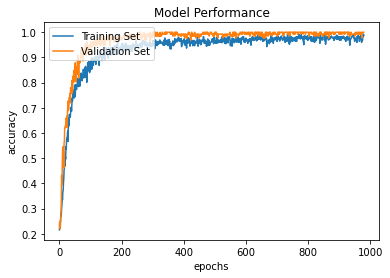

In [32]:
def plot_result(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Performance')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(['Training Set', 'Validation Set'], loc = 'upper left')
    plt.show

model = Sequential()
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 980
history = model.fit(x, y, epochs = epochs, validation_split = 0.2, batch_size = None)
plot_result(history)

model.save('my_model.h5')

As we can see from the training results above, the model achieves a training set accuracy of 0.9866 and validation set accuracy of 1.000. This means that the model should have satisfactory performance. We save the model in the project directory as 'my_model.h5'.

The cell below helps us test the performance of our model. 

In [42]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands = 1, min_detection_confidence = 0.7, min_tracking_confidence = 0.6)

cam = cv2.VideoCapture(0)
input_landmarks_list = np.array([])
while True:
    valid, img = cam.read()
    if not valid:
        print("Failed to grab frame, closing..")
        break
    height, width, channels = img.shape
    img = cv2.cvtColor(cv2.flip(img, 1), cv2.COLOR_BGR2RGB)
    img.flags.writeable = False # To improve performance, optionally mark the image as not writeable to pass by reference.
    results = hands.process(img)
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Draw the hand annotations on the image.
    if(results.multi_hand_landmarks):
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(img, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            handedness = results.multi_handedness[0].classification[0].index
            input_landmark_list = calc_landmark_list(handedness, hand_landmarks.landmark)
            result = model.predict(x = np.array([input_landmark_list]))
            if np.argmax(result) < 5:
                cv2.putText(img, class_names[np.argmax(result)], (int(width * 0.4), int(height * 0.15)), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, color = (0, 0, 255), thickness = 5)
        cv2.imshow("Landmark Hands", img)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    '''
    if k%256 == 32:
        if(results.multi_hand_landmarks):
            for hand_landmarks in results.multi_hand_landmarks:
                input_landmark_list = get_input_landmarks(hand_landmarks.landmark)
                result = model.predict(x = np.array([input_landmark_list]))
                print(str(class_names[np.argmax(result)]) + ' ' + str(result*100))
    '''            
hands.close()
cam.release()
cv2.destroyAllWindows()

Escape hit, closing...
